<a href="https://colab.research.google.com/github/MatteoGuglielmi-tech/Polarity-and-Subjectivity-Detection/blob/main/src/MyModel/BERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert-Model


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### Steps to import python files in Collaboratory
- go to Google Drive where the Jupyter Notebook containing the desired functions to import is
- download it with the .py extension
- run the following cell to put it in the content space

In this particular case we would need to import as a module the NTN file, containing the Neural Tensor Network implementation

In [5]:
from google.colab import files

files.upload()

Saving NTN.py to NTN.py


{'NTN.py': b'# -*- coding: utf-8 -*-\n"""Copy of NTN.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1-96pLYKa38EHk1zHjTD-l8fnuXagGFSl\n\n### NTN (Neural Tensor Network) [[reference_paper](https://proceedings.neurips.cc/paper/2013/file/b337e84de8752b27eda3a12363109e80-Paper.pdf)]\n\n<u><i>Goal</i></u> : state if two entities $(e_1, e_2)$ are in a certain relationship $R$.   \n>Ex. defines whehter $$(e_1, R, e_2) = (\\text{Bengal tiger}, \\text{has part}, \\text{tail})$$ is true and with which certainty.\n\n- $e_1$ and $e_2$ are vector representations or features of the two entities.\n- NTN, unlike a linear canoncical NN layer, uses a bilinear tensor layer that directly relates two entity vectors across differet dimensions.\n- Model computes a score of how likely it is two entities are in a specific position following : $$g(e_1, R, e_2) = u_R^Tf\\biggr(e_i^T W_R^{[1:K]}e_2+V_R \\begin{align}\n    \\begin{bmatr

In [6]:
import NTN

In [2]:
import pandas as pd 
import numpy as np 
import re

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import gc
from typing import Tuple, List
import torch.optim as opt

In [ ]:
root = '/content/gdrive/MyDrive/Colab Notebooks/Polarity-Subjectivity-Detection/'
pol_emb = np.load(root + 'pol.npy')
subj_emb = np.load(root + 'subj_obj.npy')

In [ ]:
print(len(pol_emb))
print(len(subj_emb))

In [ ]:
# first batch. When doing np.save everything is flatten up
# need to rebuild the features to have a list of 2k elements to spit up
print(pol_emb[:64])

In [ ]:
print(pol_emb[0].shape)

In [ ]:
pol_emb_arranged = []

for i in range(0,len(pol_emb)+1, 512):
    if i==0:
        chunk = pol_emb[:512]
    else:    
        chunk = pol_emb[i-512:i]
        pol_emb_arranged.append(chunk)

print(len(pol_emb_arranged))

In [ ]:
subj_emb_arranged = []

for i in range(0,len(pol_emb)+1, 512):
    if i==0:
        chunk = pol_emb[:512]
    else:    
        chunk = pol_emb[i-512:i]
        subj_emb_arranged.append(chunk)

print(len(subj_emb_arranged))

In [ ]:
torch.cuda.empty_cache()
gc.collect()

## Train/Test split
Preparing the data to be fed to the model

In [ ]:
senti_labels = [1 if idx<1000 else 0 for idx in range(2000)]

In [ ]:
pos = senti_labels[:1000]
neg = senti_labels[1000:]

In [ ]:
len(pos)

In [ ]:
len(neg)

In [ ]:
subj_labels = ["subj" if idx<1000 else "obj" for idx in range(2000)]

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler

def get_data(pol_embs: List, subj_embs, pol_labels: List, 
             subj_labels: List, batch_size: int, random_state=42, 
             test_split=0.2) -> Tuple[torch.utils.data.DataLoader]:

    senti_train, senti_test, sentlabel_train, sentlabel_test = train_test_split(pol_embs, 
                                                                                pol_labels,
                                                                                test_size=test_split, 
                                                                                random_state=random_state)
    
    sub_train, sub_test, sublabel_train, sublabel_test = train_test_split(subj_embs, 
                                                                          subj_labels, 
                                                                          test_size=test_split, 
                                                                          random_state=random_state)
    
    sent_train = list(zip(senti_train, sentlabel_train))
    senti_test = list(zip(senti_test, sentlabel_test))
    sub_train = list(zip(sub_train, sublabel_train))
    sub_test = list(zip(sub_test, sublabel_test))
    
    #for element in sent_train:
    #    print(f"pol : {element[0]}", f"lab : {element[1]}")
  
    
    pol_train_loader = DataLoader(dataset=senti_train, 
                              batch_size=batch_size, 
                              sampler=RandomSampler(senti_train), 
                              shuffle=False)
    
    pol_validation_loader = DataLoader(dataset=senti_test, 
                                   batch_size=batch_size,
                                   sampler=RandomSampler(senti_test), 
                                   shuffle=False)

    sub_train_loader = DataLoader(dataset=sub_train, 
                              batch_size=batch_size, 
                              sampler=RandomSampler(sub_train), 
                              shuffle=False)
    
    sub_validation_loader = DataLoader(dataset=sub_test, 
                                   batch_size=batch_size,
                                   sampler=RandomSampler(sub_test), 
                                   shuffle=False)
    
    for idx, (pol, label) in enumerate(pol_train_loader):
        print(f"idx : {idx} \n pol : {pol} \n label : {label}")
    
    return pol_train_loader, pol_validation_loader, sub_train_loader, sub_validation_loader

In [121]:
sent_train, sent_val, sub_train, sub_val = get_data(pol_embs=pol_emb_arranged, 
                                                    subj_embs=subj_emb_arranged,
                                                    pol_labels=senti_labels,
                                                    subj_labels=subj_labels,
                                                    batch_size=64)

Streaming output truncated to the last 5000 lines.
   0.19091931]
 ...
 [ 0.19111237 -0.01690451  0.34534505 ... -0.4027694  -0.11916433
  -0.16560689]
 [ 0.1785436  -0.0786357   0.32391295 ... -0.3056042  -0.18557769
  -0.23286755]
 [ 0.17309257 -0.03948178  0.35649556 ... -0.29954916 -0.17028236
  -0.23666783]] lab : 0
pol : [[-0.5952131   0.41537908 -0.20750959 ... -0.23338953  0.74336606
  -0.38361287]
 [-0.71192485  0.50390816  0.8422208  ... -0.08833965  0.34456894
  -1.1646515 ]
 [-1.2948703   0.45730507  1.3866522  ...  0.77456844  0.31086484
  -0.17576747]
 ...
 [ 0.13232923  0.54163575  0.2672271  ... -0.59766644  0.0956189
  -1.0789827 ]
 [ 0.13779669  0.37649858  0.3655214  ... -0.5759441   0.04366959
  -1.108538  ]
 [ 0.03865664  0.42321858  0.51638025 ... -0.61543846  0.16405079
  -1.0359274 ]] lab : 0
pol : [[-0.07479543  0.09447027  0.3380622  ... -0.30897215  0.2717891
  -0.02388478]
 [-0.6507925  -0.08189417  1.2111704  ... -0.13887765  0.85493106
  -0.23801002]
 [-1.

## Model assembly

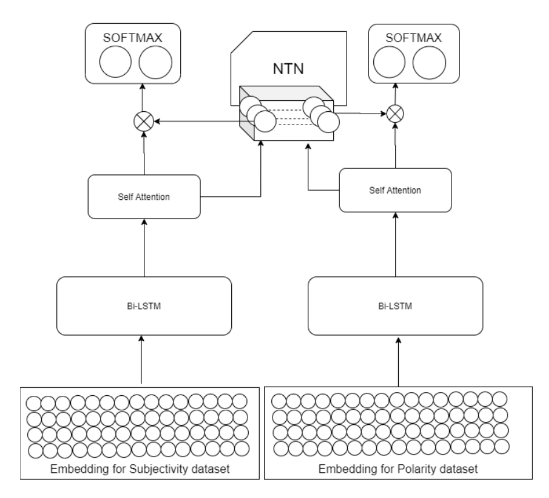

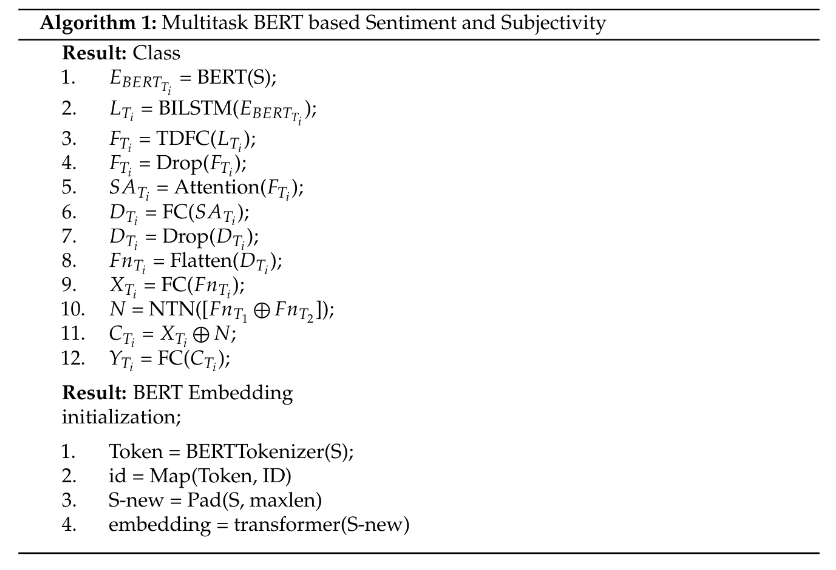


In [75]:
class MLT(nn.Module):

    def __init__(self, num_heads: int):
        super().__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.LSTM1 = nn.LSTM(input_size=(512,768), output_size=128, dropout=0.2, bidirectional=True)
        self.LSTM2 = nn.LSTM(input_size=(512,768), output_size=128, dropout=0.2, bidirectional=True)

        # dense layers
        self.dense1 = nn.Linear(in_features=128, out_features=128)
        self.dense2 = nn.Linear(in_features=128, out_features=128)
        
        # dropout layers
        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)

        # self-attention layers
        self.attention1 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads)
        self.attention2 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads)

        #self.dense11 = nn.Linear(in_features=)
        return self.attention1, self.attention2

    def forward(self, emb1, emb2) -> Tuple:
        lstm1 = self.LSTM1(emb1)
        lstm2 = self.LSTM1(emb2)

        dense1 = self.dense1(lstm1)
        dense2 = self.dense2(lstm2)

        drop1 = self.drop(dense1)
        drop2 = self.drop(dense2)

        attention_layer1 = self.attention1(drop1)
        attention_layer2 = self.attention2(drop2)

        return attention_layer1, attention_layer2
        

In [ ]:
def cross_entropy_loss():
    return torch.nn.CrossEntropyLoss()

In [ ]:
def get_optimizer(net, lr: float=0.0002):
    return opt.Adam(net.params(), lr=lr)

In [ ]:
def training_step(model, ):

In [ ]:
# history=model.fit([senti_train, sub_train], [sentlabel_train,sublabel_train], batch_size= 64, epochs=20, verbose=1, shuffle=True, validation_split=0.2)